In [1]:
import pandas as pd
import geopandas as gpd
import os
import matplotlib.pyplot as plt
import numpy as np
import contextily as ctx
from matplotlib.colors import LinearSegmentedColormap
import json

def min_max_normalize(series):
    return (series - series.min()) / (series.max() - series.min())

def standardize(series):
    return (series - series.mean()) / series.std()

Found 7 ZIP codes with impossible locations
Found 39 ZIP codes adjacent to existing stores

Top 5 Potential Locations for New Trader Joe's Stores:


ZCTA  tj_score  Median_Household_Income  Percent_25_to_44  \
103  11215  0.599609                 223697.0              39.5   
109  11222  0.459920                 148503.0              53.6   
81   11102  0.322131                 115290.0              44.7   
40   10044  0.245931                 137901.0              37.5   
37   11105  0.159694                 111418.0              42.2   

     subway_density  crime_density_inverse  parking_density  \
103        1.230141             312.845150          0.00000   
109        0.505307             309.062085          0.00000   
81         0.978340             311.626872          0.48917   
40         1.707142             329.765793          0.00000   
37         0.230084             330.768313          0.00000   

     distance_to_truck_route_inverse  Median_Gross_Rent  Median_Home_Value  
103                         0.024407             2803.0          1674700.0  
109                         0.023614             2595.0          1245600.0  
81                          0.025726             2248.0           779800.0  
40                          0.020067             3305.0          1041300.0  
37                          0.025263             2211.0          1089000.0


Comprehensive Analysis of Top Locations:


ZCTA Overall Score Median Income College Educated Population  \
103  11215          0.60      $223,697            59.9%     70,922   
109  11222          0.46      $148,503            52.8%     41,418   
81   11102          0.32      $115,290            46.2%     28,349   
40   10044          0.25      $137,901            54.7%     11,998   
37   11105          0.16      $111,418            42.5%     38,507   

    Young Adults White Pop. Asian Pop. Subway Density Parking Density  \
103        39.5%      71.2%       9.1%   1.23 per km²    0.00 per km²   
109        53.6%      71.0%       5.8%   0.51 per km²    0.00 per km²   
81         44.7%      52.0%      15.7%   0.98 per km²    0.49 per km²   
40         37.5%      42.2%      29.5%   1.71 per km²    0.00 per km²   
37         42.2%      65.1%      10.7%   0.23 per km²    0.00 per km²   

    Safety Score Truck Access Median Rent Median Home Value  Land Area  
103        312.8        0.024      $2,803        $1,674,700   5.690406  
109        309.1        0.024      $2,595        $1,245,600   3.957993  
81         311.6        0.026      $2,248          $779,800   2.044278  
40         329.8        0.020      $3,305        $1,041,300   0.585774  
37         330.8        0.025      $2,211        $1,089,000   4.346239

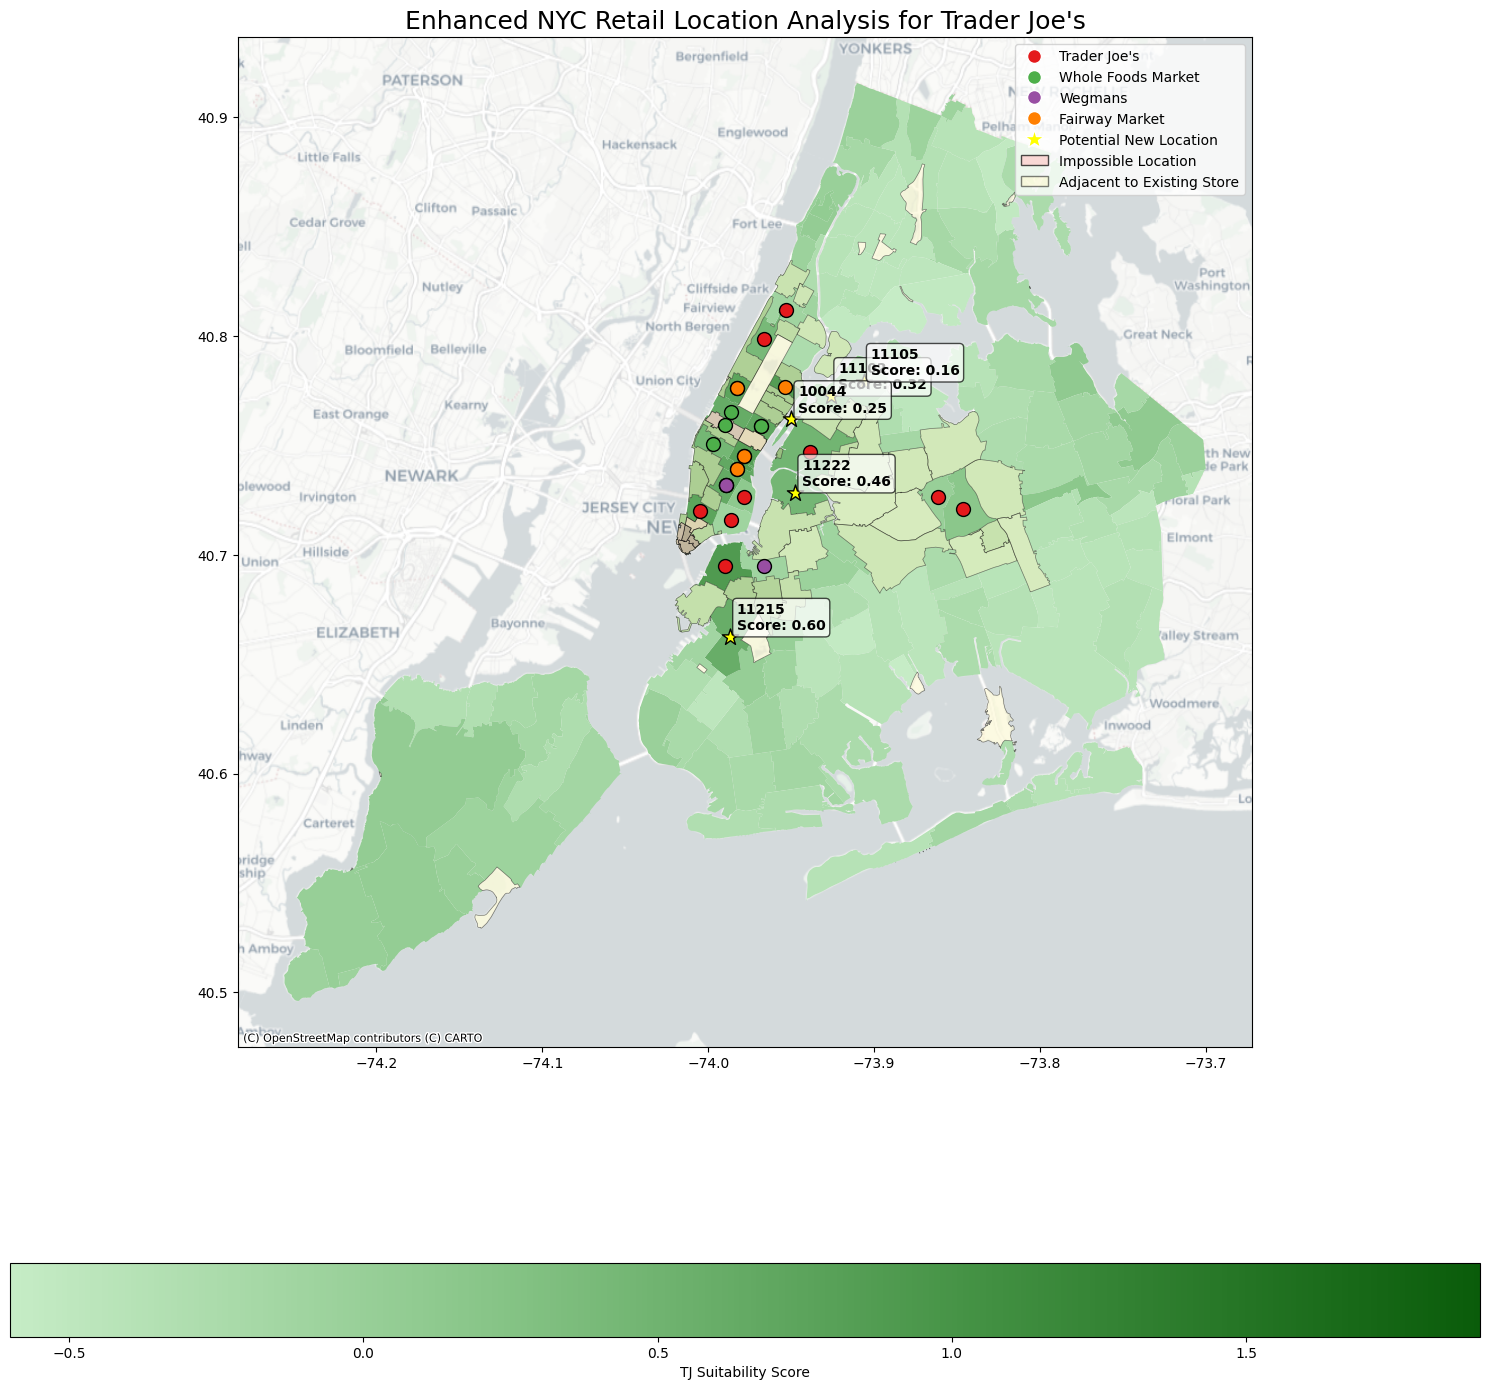

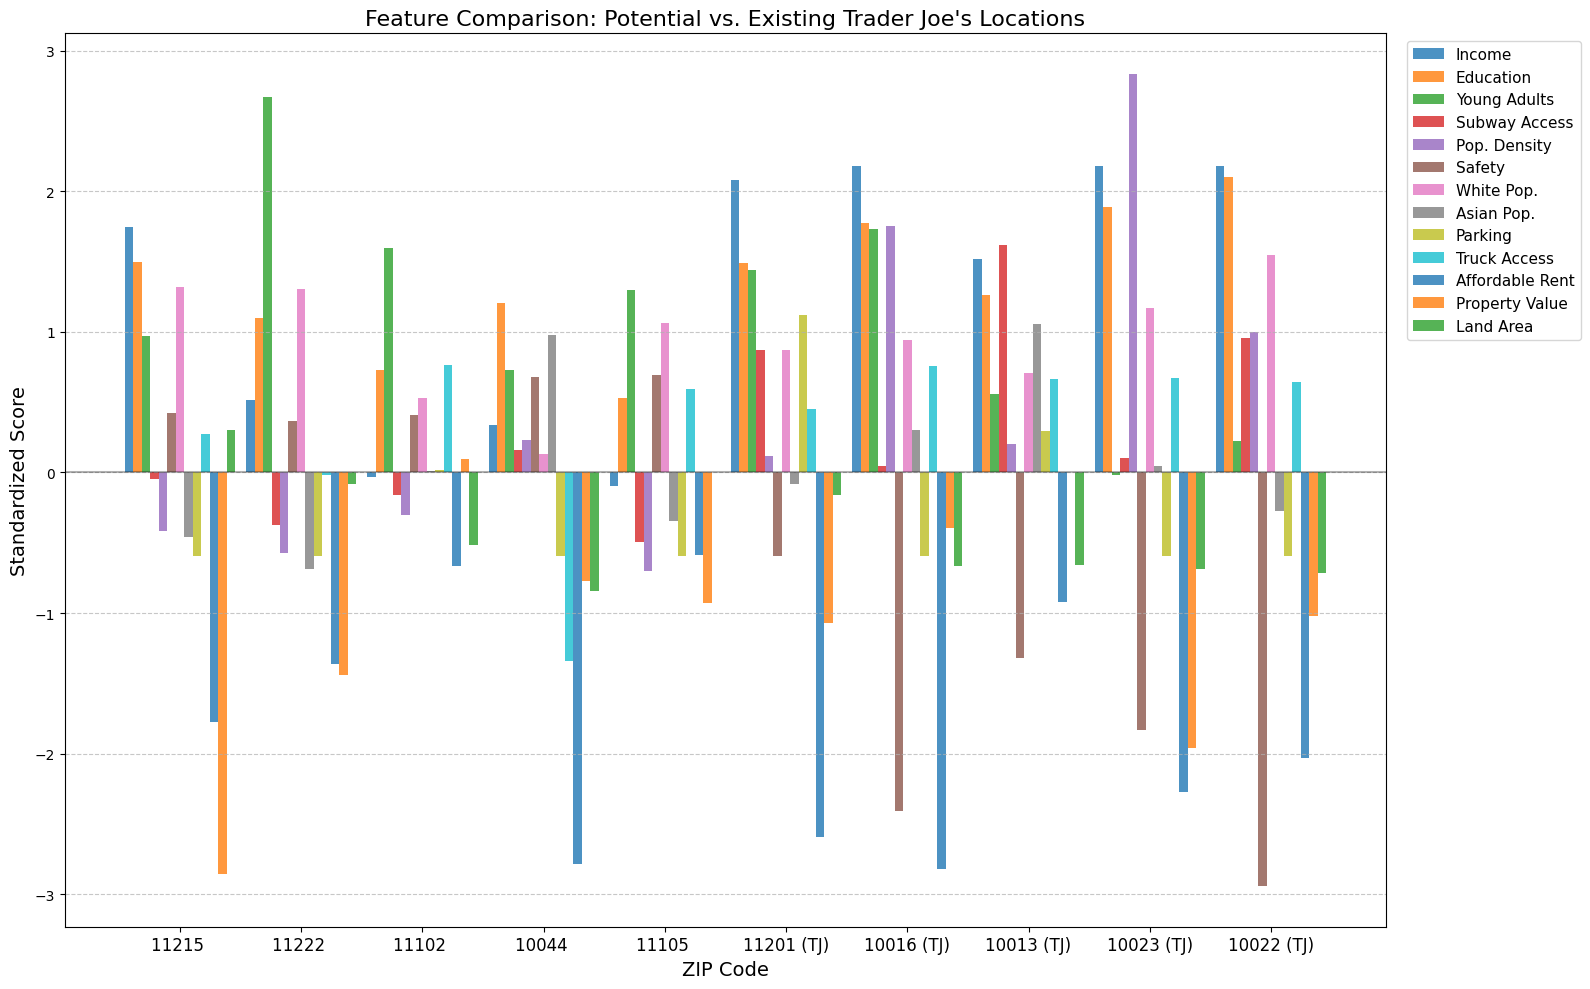

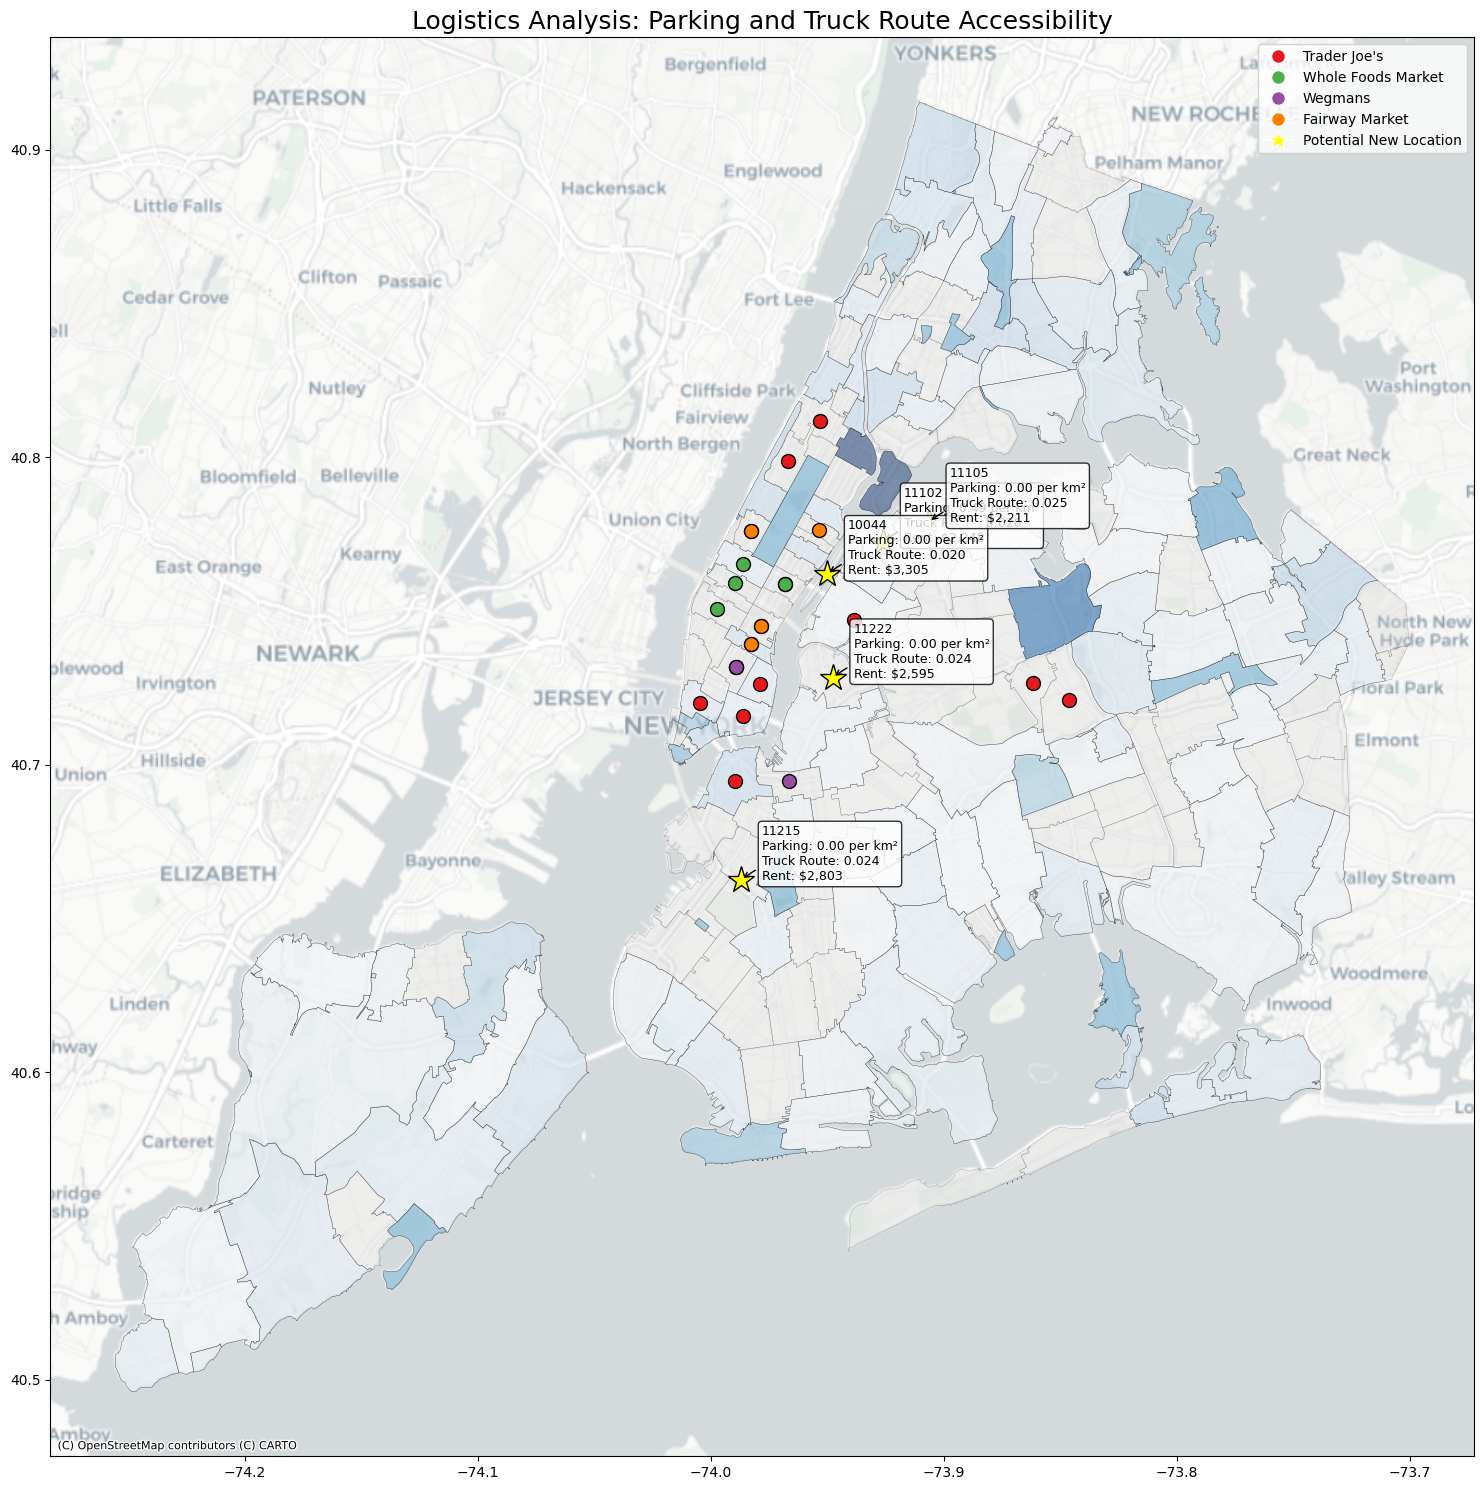

In [10]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import json
import contextily as ctx
from matplotlib.colors import LinearSegmentedColormap
import warnings
warnings.filterwarnings('ignore')

def min_max_normalize(series):
    if series.max() == series.min():
        return series / series.max() if series.max() > 0 else pd.Series(0, index=series.index)
    return (series - series.min()) / (series.max() - series.min())

def standardize(series):
    return (series - series.mean()) / series.std()

# Load the data
nyc_data = gpd.read_file('cleaned_data/nyc_ZCTA_raw_features.geojson')

# Load existing stores data
with open('data/existing_shops_zip_code.json', 'r') as f:
    existing_stores = json.load(f)

# Load impossible locations data
with open('data/impossible_places.json', 'r') as f:
    impossible_places = json.load(f)

# Create a set of all impossible ZIP codes
impossible_zips = set()
for place in impossible_places:
    if place["zipcode"]:  # Some might be null
        impossible_zips.add(place["zipcode"])

print(f"Found {len(impossible_zips)} ZIP codes with impossible locations")

rent_inverse = pd.Series(nyc_data['rent_inverse'])
home_value_inverse = pd.Series(nyc_data['home_value_inverse'])

# Fill missing values with mean
rent_inverse = rent_inverse.fillna(rent_inverse.mean())
home_value_inverse = home_value_inverse.fillna(home_value_inverse.mean())

nyc_data['rent_score'] = standardize(rent_inverse)
nyc_data['home_value_score'] = standardize(home_value_inverse)

# Create standardized feature scores for each ZIP code area
nyc_data['income_score'] = standardize(nyc_data['Median_Household_Income'])
nyc_data['education_score'] = standardize(nyc_data['Bachelors_Degree_or_Higher'] / nyc_data['Total_Population'])
nyc_data['young_adult_score'] = standardize(nyc_data['Percent_25_to_44'])
nyc_data['population_density_score'] = standardize(nyc_data['Total_Population'] / nyc_data['area_sqkm']) 
nyc_data['subway_score'] = standardize(nyc_data['subway_density'])
nyc_data['white_pop_score'] = standardize(nyc_data['Percent_White'])
nyc_data['asian_pop_score'] = standardize(nyc_data['Percent_Asian'])
nyc_data['safety_score'] = standardize(nyc_data['crime_density_inverse'])

# Add new logistics and real estate features
nyc_data['parking_score'] = standardize(nyc_data['parking_density'])
nyc_data['truck_access_score'] = standardize(nyc_data['distance_to_truck_route_inverse'])
nyc_data['land_size_score'] = standardize(nyc_data['area_sqkm'])

# Create an enhanced composite suitability score with weighted features
nyc_data['tj_score'] = (
    0.20 * nyc_data['income_score'] +           # High income areas
    0.15 * nyc_data['education_score'] +        # Educated population
    0.12 * nyc_data['young_adult_score'] +      # Young adults (25-44)
    0.12 * nyc_data['subway_score'] +           # Good public transportation
    0.08 * nyc_data['population_density_score'] + # Dense population
    0.08 * nyc_data['safety_score'] +           # Safe area
    0.06 * nyc_data['white_pop_score'] +        # Demographics
    0.04 * nyc_data['asian_pop_score'] +        # Demographics
    0.05 * nyc_data['parking_score'] +          # Parking availability
    0.05 * nyc_data['truck_access_score'] +     # Delivery truck access
    0.03 * nyc_data['rent_score'] +             # Affordable rent
    0.03 * nyc_data['home_value_score'] +       # Property value considerations
    0.03 * nyc_data['land_size_score']          # Adequate land area for store
)

# Mark ZIP codes with existing Trader Joe's and competitors
nyc_data['has_trader_joes'] = nyc_data['ZCTA'].isin(existing_stores["Trader Joe's"])
nyc_data['has_whole_foods'] = nyc_data['ZCTA'].isin(existing_stores["Whole Foods Market"])
nyc_data['has_wegmans'] = nyc_data['ZCTA'].isin(existing_stores["Wegmans"])
nyc_data['has_fairway'] = nyc_data['ZCTA'].isin(existing_stores["Fairway Market"])
nyc_data['has_competitor'] = (nyc_data['has_whole_foods'] | nyc_data['has_wegmans'] | nyc_data['has_fairway'])
nyc_data['has_any_store'] = nyc_data['has_trader_joes'] | nyc_data['has_competitor']
nyc_data['is_impossible_location'] = nyc_data['ZCTA'].isin(impossible_zips)

# Find adjacent ZIP codes to avoid market cannibalization
adjacent_zips = set()
existing_areas = nyc_data[nyc_data['has_any_store']]

for idx, area in nyc_data.iterrows():
    # Check if this area touches any existing store area
    if any(area.geometry.touches(existing.geometry) for _, existing in existing_areas.iterrows()):
        adjacent_zips.add(area['ZCTA'])

# Remove the existing ZIP codes from adjacent ZIP codes (they're already excluded)
adjacent_zips = adjacent_zips - set(nyc_data[nyc_data['has_any_store']]['ZCTA'])
nyc_data['is_adjacent_to_store'] = nyc_data['ZCTA'].isin(adjacent_zips)

print(f"Found {len(adjacent_zips)} ZIP codes adjacent to existing stores")

# Find potential new locations (high score, no existing stores, not impossible locations)
potential_locations = nyc_data[
    (~nyc_data['has_any_store']) & 
    (~nyc_data['is_impossible_location']) &
    (~nyc_data['is_adjacent_to_store']) &
    (nyc_data['tj_score'] > nyc_data['tj_score'].quantile(0.60))
].sort_values('tj_score', ascending=False).head(5)



# Create a visualization
fig, ax = plt.subplots(figsize=(15, 15))

# Create a custom colormap from light to dark blue
cmap = LinearSegmentedColormap.from_list('TJ_colors', ['#c6ecc6', '#86c486', '#429042', '#0a5c0a'])

# Plot the base map with suitability scores
nyc_data.plot(
    column='tj_score',
    cmap=cmap,
    legend=True,
    legend_kwds={'label': 'TJ Suitability Score', 'orientation': 'horizontal'},
    ax=ax
)

# Add a background map
ctx.add_basemap(ax, crs=nyc_data.crs.to_string(), source=ctx.providers.CartoDB.Positron)

# Highlight impossible locations in light red
impossible_areas = nyc_data[nyc_data['is_impossible_location']]
impossible_areas.plot(ax=ax, color='#ffcccc', edgecolor='black', linewidth=0.5, alpha=0.7)

# Highlight areas adjacent to existing stores in light yellow
adjacent_areas = nyc_data[nyc_data['is_adjacent_to_store']]
adjacent_areas.plot(ax=ax, color='#fffacd', edgecolor='black', linewidth=0.5, alpha=0.5)

# Define colors for different store types
store_colors = {
    "Trader Joe's": '#e41a1c',       # Red
    "Whole Foods Market": '#4daf4a',  # Green
    "Wegmans": '#984ea3',             # Purple
    "Fairway Market": '#ff7f00'       # Orange
}

# Create legend handles
legend_handles = []

# Plot each store type
for store_name, color in store_colors.items():
    # Get ZIP codes with this store
    store_zips = existing_stores[store_name]
    store_locations = nyc_data[nyc_data['ZCTA'].isin(store_zips)].copy()
    
    if not store_locations.empty:
        # Calculate centroids for markers
        store_locations['centroid'] = store_locations.geometry.centroid
        store_locations_points = gpd.GeoDataFrame(
            store_locations[['ZCTA']], 
            geometry=store_locations['centroid'],
            crs=store_locations.crs
        )
        # Plot store markers
        store_locations_points.plot(
            ax=ax, 
            color=color, 
            markersize=100, 
            marker='o', 
            edgecolor='black',
            label=store_name
        )
        
        # Add a legend entry
        legend_handles.append(plt.Line2D(
            [0], [0], 
            marker='o', 
            color='w', 
            markerfacecolor=color, 
            markersize=10, 
            label=store_name
        ))

# Plot potential locations
potential_locations['centroid'] = potential_locations.geometry.centroid
potential_locations_points = gpd.GeoDataFrame(
    potential_locations[['ZCTA', 'tj_score']], 
    geometry=potential_locations['centroid'],
    crs=potential_locations.crs
)

potential_locations_points.plot(
    ax=ax,
    color='yellow',
    markersize=150,
    marker='*',
    edgecolor='black',
    linewidth=1
)

# Add potential locations to legend
legend_handles.append(plt.Line2D(
    [0], [0], 
    marker='*', 
    color='w', 
    markerfacecolor='yellow', 
    markersize=15, 
    label='Potential New Location'
))

# Add impossible and adjacent locations to legend
legend_handles.append(plt.Rectangle((0,0), 1, 1, fc='#ffcccc', ec='black', alpha=0.7, label='Impossible Location'))
legend_handles.append(plt.Rectangle((0,0), 1, 1, fc='#fffacd', ec='black', alpha=0.5, label='Adjacent to Existing Store'))

# Add ZIP code labels for potential locations
for idx, row in potential_locations.iterrows():
    ax.annotate(
        f"{row['ZCTA']}\nScore: {row['tj_score']:.2f}",
        xy=(row['centroid'].x, row['centroid'].y),
        xytext=(5, 5),
        textcoords="offset points",
        fontsize=10,
        fontweight='bold',
        bbox=dict(boxstyle="round,pad=0.3", fc='white', ec='black', alpha=0.7)
    )

# Add legend
ax.legend(handles=legend_handles, loc='upper right', fontsize=10)

# Set title and labels
ax.set_title('Enhanced NYC Retail Location Analysis for Trader Joe\'s', fontsize=18)
plt.tight_layout()

# Print detailed information about potential locations
print("\nTop 5 Potential Locations for New Trader Joe's Stores:")
potential_details = potential_locations[[
    'ZCTA', 'tj_score', 'Median_Household_Income', 'Percent_25_to_44', 
    'subway_density', 'crime_density_inverse', 'parking_density', 
    'distance_to_truck_route_inverse', 'Median_Gross_Rent', 'Median_Home_Value'
]]
display(potential_details)

# Create a visualization to compare feature scores across potential locations
fig2, ax2 = plt.subplots(figsize=(16, 10))

# List of features to compare
features = [
    'income_score', 'education_score', 'young_adult_score', 
    'subway_score', 'population_density_score', 'safety_score',
    'white_pop_score', 'asian_pop_score', 'parking_score', 
    'truck_access_score', 'rent_score', 'home_value_score', 'land_size_score'
]

feature_labels = {
    'income_score': 'Income',
    'education_score': 'Education',
    'young_adult_score': 'Young Adults',
    'subway_score': 'Subway Access',
    'population_density_score': 'Pop. Density',
    'safety_score': 'Safety',
    'white_pop_score': 'White Pop.',
    'asian_pop_score': 'Asian Pop.',
    'parking_score': 'Parking',
    'truck_access_score': 'Truck Access',
    'rent_score': 'Affordable Rent',
    'home_value_score': 'Property Value',
    'land_size_score': 'Land Area'
}

# Get top potential locations and 3 existing TJ locations for comparison
existing_tj = nyc_data[nyc_data['has_trader_joes']].sort_values('tj_score', ascending=False).head(5)
compare_locations = pd.concat([potential_locations, existing_tj])

# Create a bar chart comparing features
x = np.arange(len(compare_locations))
width = 0.07
multiplier = 0

# Add feature bars
for feature in features:
    offset = width * multiplier
    rects = ax2.bar(
        x + offset, 
        compare_locations[feature], 
        width, 
        label=feature_labels.get(feature, feature.replace('_score', '')),
        alpha=0.8
    )
    multiplier += 1

# Add a horizontal line at y=0 for reference
ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)

# Add labels and title
ax2.set_xlabel('ZIP Code', fontsize=14)
ax2.set_ylabel('Standardized Score', fontsize=14)
ax2.set_title('Feature Comparison: Potential vs. Existing Trader Joe\'s Locations', fontsize=16)
ax2.set_xticks(x + width * (len(features) - 1) / 2)
ax2.set_xticklabels([
    f"{row['ZCTA']} {'(TJ)' if row['has_trader_joes'] else ''}" 
    for _, row in compare_locations.iterrows()
], fontsize=12)
ax2.legend(loc='upper left', bbox_to_anchor=(1.01, 1), fontsize=11)
ax2.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()

# Create a logistics-focused visualization
fig3, ax3 = plt.subplots(figsize=(15, 15))

# Plot the base map
nyc_data.plot(
    color='lightgrey',
    edgecolor='black',
    linewidth=0.3,
    alpha=0.3,
    ax=ax3
)

# Add a background map
ctx.add_basemap(ax3, crs=nyc_data.crs.to_string(), source=ctx.providers.CartoDB.Positron)

# Plot parking density
parking_areas = nyc_data[nyc_data['parking_density'] > 0].copy()
parking_areas.plot(
    column='parking_density',
    cmap='Blues',
    alpha=0.5,
    edgecolor='black',
    linewidth=0.3,
    ax=ax3
)

# Plot existing stores
for store_name, color in store_colors.items():
    store_zips = existing_stores[store_name]
    store_locations = nyc_data[nyc_data['ZCTA'].isin(store_zips)].copy()
    
    if not store_locations.empty:
        store_locations['centroid'] = store_locations.geometry.centroid
        store_locations_points = gpd.GeoDataFrame(
            store_locations[['ZCTA']], 
            geometry=store_locations['centroid'],
            crs=store_locations.crs
        )
        store_locations_points.plot(
            ax=ax3, 
            color=color, 
            markersize=100, 
            marker='o', 
            edgecolor='black'
        )

# Plot potential locations with detailed annotations
for idx, row in potential_locations.iterrows():
    ax3.plot(
        row['centroid'].x, 
        row['centroid'].y, 
        marker='*', 
        markersize=20,
        color='yellow', 
        markeredgecolor='black',
        markeredgewidth=1
    )
    
    # Add a detailed annotation with logistics info
    rent = f"${int(row['Median_Gross_Rent']):,}" if not pd.isna(row['Median_Gross_Rent']) else "N/A"
    ax3.annotate(
        f"{row['ZCTA']}\n"
        f"Parking: {row['parking_density']:.2f} per km²\n"
        f"Truck Route: {row['distance_to_truck_route_inverse']:.3f}\n"
        f"Rent: {rent}",
        xy=(row['centroid'].x, row['centroid'].y),
        xytext=(15, 0),
        textcoords="offset points",
        fontsize=9,
        bbox=dict(boxstyle="round,pad=0.3", fc='white', ec='black', alpha=0.8),
        arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=0.2")
    )

# Create legend
ax3_legend_handles = []
for store_name, color in store_colors.items():
    ax3_legend_handles.append(plt.Line2D(
        [0], [0], 
        marker='o', 
        color='w', 
        markerfacecolor=color, 
        markersize=10, 
        label=store_name
    ))
ax3_legend_handles.append(plt.Line2D(
    [0], [0], 
    marker='*', 
    color='w', 
    markerfacecolor='yellow', 
    markersize=15, 
    label='Potential New Location'
))

# Add legend
ax3.legend(handles=ax3_legend_handles, loc='upper right', fontsize=10)

# Set title
ax3.set_title('Logistics Analysis: Parking and Truck Route Accessibility', fontsize=18)

plt.tight_layout()

# Final summary table with all key metrics for top locations
summary_table = potential_locations[[
    'ZCTA', 'tj_score', 'Median_Household_Income', 'Bachelors_Degree_or_Higher',
    'Total_Population', 'Percent_25_to_44', 'Percent_White', 'Percent_Asian',
    'subway_density', 'parking_density', 'crime_density_inverse',
    'distance_to_truck_route_inverse', 'Median_Gross_Rent', 'Median_Home_Value', 'area_sqkm'
]].copy()

# Format the summary table for better readability
summary_table['tj_score'] = summary_table['tj_score'].apply(lambda x: f"{x:.2f}")
summary_table['Median_Household_Income'] = summary_table['Median_Household_Income'].apply(lambda x: f"${int(x):,}")
summary_table['Bachelors_Degree_or_Higher'] = summary_table.apply(
    lambda x: f"{x['Bachelors_Degree_or_Higher'] / x['Total_Population'] * 100:.1f}%", 
    axis=1
)
summary_table['Total_Population'] = summary_table['Total_Population'].apply(lambda x: f"{int(x):,}")
summary_table['Percent_25_to_44'] = summary_table['Percent_25_to_44'].apply(lambda x: f"{x}%")
summary_table['Percent_White'] = summary_table['Percent_White'].apply(lambda x: f"{x}%")
summary_table['Percent_Asian'] = summary_table['Percent_Asian'].apply(lambda x: f"{x}%")
summary_table['subway_density'] = summary_table['subway_density'].apply(lambda x: f"{x:.2f} per km²")
summary_table['parking_density'] = summary_table['parking_density'].apply(lambda x: f"{x:.2f} per km²")
summary_table['crime_density_inverse'] = summary_table['crime_density_inverse'].apply(lambda x: f"{x:.1f}")
summary_table['distance_to_truck_route_inverse'] = summary_table['distance_to_truck_route_inverse'].apply(lambda x: f"{x:.3f}")
summary_table['Median_Gross_Rent'] = summary_table['Median_Gross_Rent'].apply(
    lambda x: f"${int(x):,}" if not pd.isna(x) else "N/A"
)
summary_table['Median_Home_Value'] = summary_table['Median_Home_Value'].apply(
    lambda x: f"${int(x):,}" if not pd.isna(x) else "N/A"
)

# Rename columns for better readability
summary_table = summary_table.rename(columns={
    'tj_score': 'Overall Score',
    'Median_Household_Income': 'Median Income',
    'Bachelors_Degree_or_Higher': 'College Educated',
    'Total_Population': 'Population',
    'Percent_25_to_44': 'Young Adults',
    'Percent_White': 'White Pop.',
    'Percent_Asian': 'Asian Pop.',
    'subway_density': 'Subway Density',
    'parking_density': 'Parking Density',
    'crime_density_inverse': 'Safety Score',
    'distance_to_truck_route_inverse': 'Truck Access',
    'Median_Gross_Rent': 'Median Rent',
    'Median_Home_Value': 'Median Home Value',
    'area_sqkm': 'Land Area',
})

print("\nComprehensive Analysis of Top Locations:")
display(summary_table)

plt.show()

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler
import seaborn as sns

import matplotlib.pyplot as plt

# Create a copy of nyc_data for our analysis
model_data = nyc_data.copy()

# Create target variable (1 for Trader Joe's, 0 for no Trader Joe's)
model_data['has_tj'] = model_data['has_trader_joes'].astype(int)

# Filter out impossible locations and areas with missing values
model_data = model_data[~model_data['is_impossible_location']]
model_data = model_data.dropna(subset=['tj_score', 'income_score', 'education_score',
                                      'young_adult_score', 'subway_score',
                                      'population_density_score', 'safety_score'])

# Select features for our model
features = [
    'income_score', 'education_score', 'young_adult_score',
    'subway_score', 'population_density_score', 'safety_score',
    'white_pop_score', 'asian_pop_score', 'parking_score',
    'truck_access_score', 'rent_score', 'home_value_score'
]

X = model_data[features]
y = model_data['has_tj']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train logistic regression model
model = LogisticRegression(class_weight='balanced', random_state=42)
model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = model.predict(X_test_scaled)
y_prob = model.predict_proba(X_test_scaled)[:, 1]

# Evaluate model
print("Model Performance:")
print(classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob))

Model Performance:
              precision    recall  f1-score   support

           0       0.95      0.82      0.88        44
           1       0.38      0.71      0.50         7

    accuracy                           0.80        51
   macro avg       0.67      0.77      0.69        51
weighted avg       0.87      0.80      0.83        51

ROC AUC Score: 0.8311688311688312


Top 5 locations predicted by the machine learning model:


ZCTA  model_score  tj_score  Median_Household_Income  Percent_25_to_44  \
128  11354     0.748512 -0.311803                  67399.0              25.5   
129  11355     0.735728 -0.274302                  56852.0              26.6   
81   11102     0.726306  0.322131                 115290.0              44.7   
35   10040     0.663291  0.078187                  76442.0              32.0   
133  11372     0.636633 -0.168851                  79371.0              29.5   

     subway_density  parking_density  
128        0.175928         0.175928  
129        0.000000         0.663963  
81         0.978340         0.489170  
35         4.059237         0.000000  
133        1.566285         0.000000


Comparison of Expert and ML Model Recommendations:


ZCTA Expert Score ML Score Median Income Young Adults Subway Density  \
128  11354        -0.31     0.75       $67,399        25.5%   0.18 per km²   
129  11355        -0.27     0.74       $56,852        26.6%   0.00 per km²   
81   11102         0.32     0.73      $115,290        44.7%   0.98 per km²   
35   10040         0.08     0.66       $76,442        32.0%   4.06 per km²   
133  11372        -0.17     0.64       $79,371        29.5%   1.57 per km²   
109  11222         0.46     0.21      $148,503        53.6%   0.51 per km²   
103  11215         0.60     0.01      $223,697        39.5%   1.23 per km²   

    Parking Density  Safety Score  Truck Access  
128    0.18 per km²    314.922599      0.021498  
129    0.66 per km²    308.011593      0.025191  
81     0.49 per km²    311.626872      0.025726  
35     0.00 per km²    270.356674      0.024768  
133    0.00 per km²    248.923721      0.021879  
109    0.00 per km²    309.062085      0.023614  
103    0.00 per km²    312.845150      0.024407

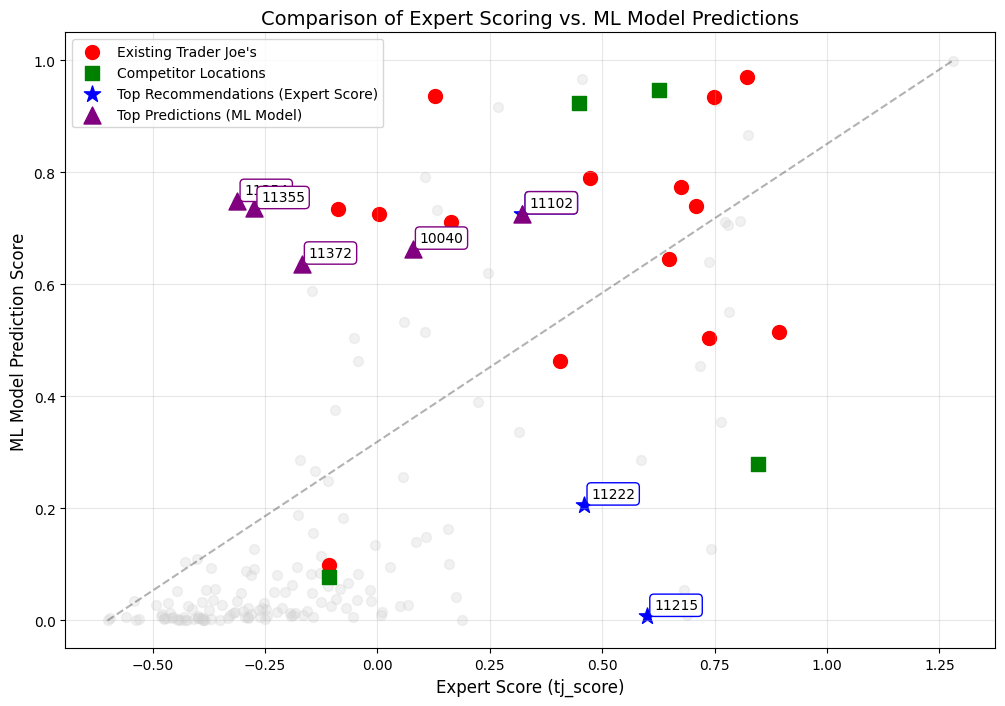

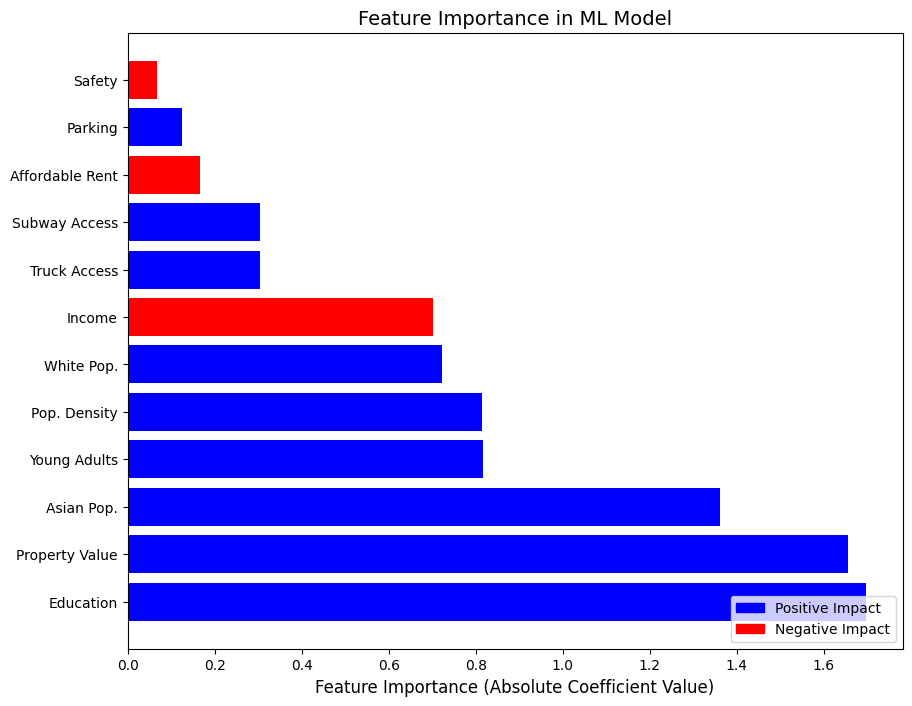

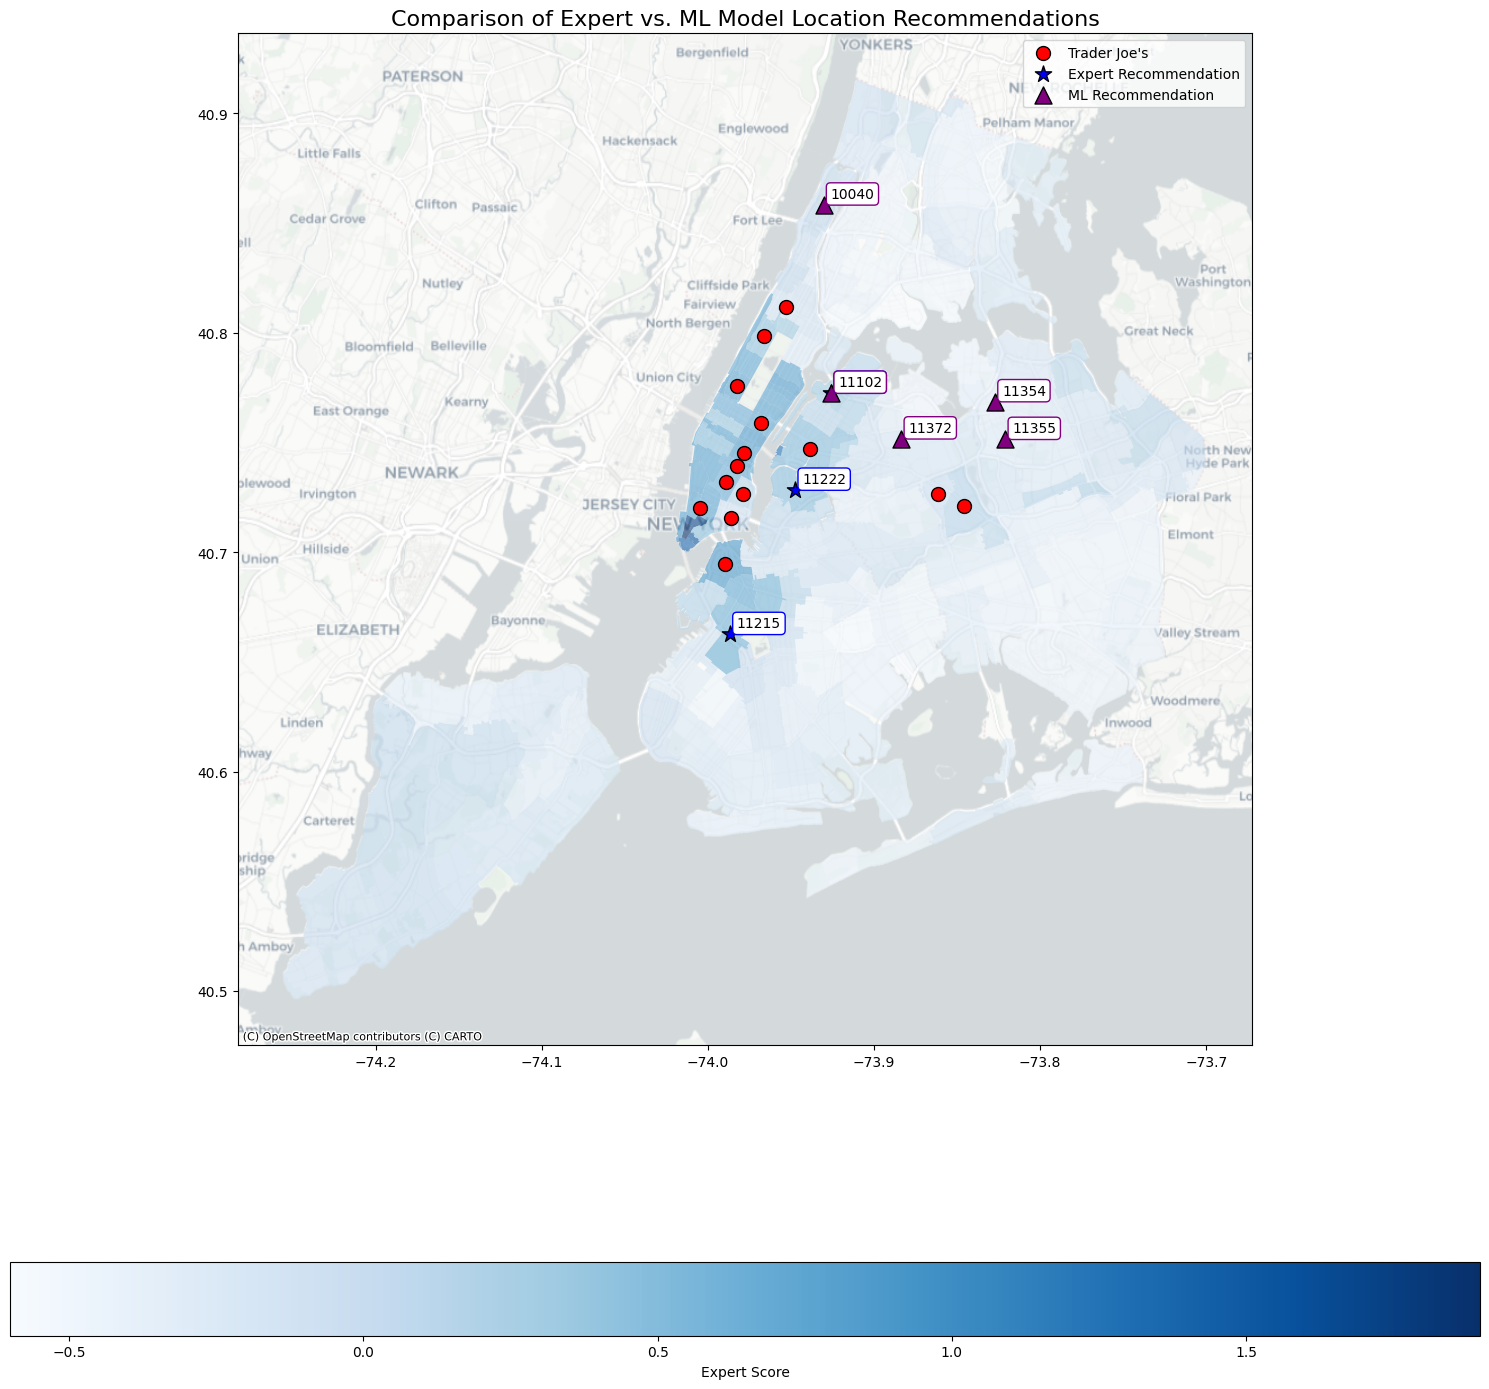

In [5]:
# Use the trained model to make predictions on all ZIP codes
X_all = model_data[features]
X_all_scaled = scaler.transform(X_all)
model_data['model_score'] = model.predict_proba(X_all_scaled)[:, 1]

# Get top potential locations based on model predictions
# Exclude existing stores, impossible locations, and adjacent areas
top_predictions = model_data[
    (~model_data['has_any_store']) & 
    (~model_data['is_impossible_location']) &
    (~model_data['is_adjacent_to_store'])
].sort_values('model_score', ascending=False).head(5)

print(f"Top 5 locations predicted by the machine learning model:")
display(top_predictions[['ZCTA', 'model_score', 'tj_score', 'Median_Household_Income', 
                        'Percent_25_to_44', 'subway_density', 'parking_density']])

# Create visualization comparing expert scoring with ML predictions
fig, ax = plt.subplots(figsize=(12, 8))

# Plot all ZIP codes
ax.scatter(
    model_data['tj_score'], 
    model_data['model_score'], 
    alpha=0.3, 
    c='lightgray', 
    s=50
)

# Highlight existing TJ locations
existing_tj = model_data[model_data['has_trader_joes']]
ax.scatter(
    existing_tj['tj_score'], 
    existing_tj['model_score'], 
    color='red', 
    s=100, 
    label="Existing Trader Joe's"
)

# Highlight competitor locations
competitors = model_data[(model_data['has_competitor']) & (~model_data['has_trader_joes'])]
ax.scatter(
    competitors['tj_score'], 
    competitors['model_score'], 
    color='green', 
    s=100, 
    marker='s', 
    label='Competitor Locations'
)

# Highlight top recommendations from TJ score
top_from_tj = model_data[
    (~model_data['has_any_store']) & 
    (~model_data['is_impossible_location']) &
    (~model_data['is_adjacent_to_store'])
].sort_values('tj_score', ascending=False).head(3)

ax.scatter(
    top_from_tj['tj_score'], 
    top_from_tj['model_score'], 
    color='blue', 
    s=150, 
    marker='*',
    label='Top Recommendations (Expert Score)'
)

# Highlight top predictions from ML model
ax.scatter(
    top_predictions['tj_score'], 
    top_predictions['model_score'], 
    color='purple', 
    s=150, 
    marker='^',
    label='Top Predictions (ML Model)'
)

# Add ZIP code labels for top recommendations
for idx, row in top_from_tj.iterrows():
    ax.annotate(
        row['ZCTA'],
        xy=(row['tj_score'], row['model_score']),
        xytext=(5, 5),
        textcoords="offset points",
        fontsize=10,
        bbox=dict(boxstyle="round,pad=0.3", fc='white', ec='blue')
    )

# Add ZIP code labels for top predictions
for idx, row in top_predictions.iterrows():
    ax.annotate(
        row['ZCTA'],
        xy=(row['tj_score'], row['model_score']),
        xytext=(5, 5),
        textcoords="offset points",
        fontsize=10,
        bbox=dict(boxstyle="round,pad=0.3", fc='white', ec='purple')
    )

# Add diagonal line for reference
min_score = min(model_data['tj_score'].min(), 0)
max_score = max(model_data['tj_score'].max(), 1)
ax.plot([min_score, max_score], [0, 1], 'k--', alpha=0.3)

# Add labels and title
ax.set_xlabel('Expert Score (tj_score)', fontsize=12)
ax.set_ylabel('ML Model Prediction Score', fontsize=12)
ax.set_title('Comparison of Expert Scoring vs. ML Model Predictions', fontsize=14)
ax.grid(True, alpha=0.3)
ax.legend(loc='upper left')

# Create a table showing feature importance from the model
coefficients = model.coef_[0]
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': np.abs(coefficients),
    'Direction': np.sign(coefficients)
})
feature_importance = feature_importance.sort_values('Importance', ascending=False)

# Create a horizontal bar chart for feature importance
fig2, ax2 = plt.subplots(figsize=(10, 8))
colors = ['red' if x < 0 else 'blue' for x in feature_importance['Direction']]
bars = ax2.barh(
    feature_importance['Feature'], 
    feature_importance['Importance'],
    color=colors
)

# Add labels
ax2.set_xlabel('Feature Importance (Absolute Coefficient Value)', fontsize=12)
ax2.set_title('Feature Importance in ML Model', fontsize=14)
ax2.set_yticklabels([feature_labels.get(f, f) for f in feature_importance['Feature']])

# Add legend
import matplotlib.patches as mpatches
blue_patch = mpatches.Patch(color='blue', label='Positive Impact')
red_patch = mpatches.Patch(color='red', label='Negative Impact')
ax2.legend(handles=[blue_patch, red_patch], loc='lower right')

# Create a map visualization with both expert and ML recommendations
fig3, ax3 = plt.subplots(figsize=(15, 15))

# Plot the base map with expert scores
nyc_data.plot(
    column='tj_score',
    cmap='Blues',
    legend=True,
    legend_kwds={'label': 'Expert Score', 'orientation': 'horizontal'},
    alpha=0.6,
    ax=ax3
)

# Add a background map
ctx.add_basemap(ax3, crs=nyc_data.crs.to_string(), source=ctx.providers.CartoDB.Positron)

# Plot existing Trader Joe's
tj_locations = nyc_data[nyc_data['has_trader_joes']]
tj_locations['centroid'] = tj_locations.geometry.centroid
tj_locations_points = gpd.GeoDataFrame(
    tj_locations[['ZCTA']], 
    geometry=tj_locations['centroid'],
    crs=tj_locations.crs
)
tj_locations_points.plot(
    ax=ax3, 
    color='red', 
    markersize=100, 
    marker='o', 
    edgecolor='black',
    label="Trader Joe's"
)

# Plot expert recommendations
top_from_tj['centroid'] = top_from_tj.geometry.centroid
top_from_tj_points = gpd.GeoDataFrame(
    top_from_tj[['ZCTA']], 
    geometry=top_from_tj['centroid'],
    crs=top_from_tj.crs
)
top_from_tj_points.plot(
    ax=ax3, 
    color='blue', 
    markersize=150, 
    marker='*', 
    edgecolor='black',
    label='Expert Recommendation'
)

# Plot ML recommendations
top_predictions['centroid'] = top_predictions.geometry.centroid
top_predictions_points = gpd.GeoDataFrame(
    top_predictions[['ZCTA']], 
    geometry=top_predictions['centroid'],
    crs=top_predictions.crs
)
top_predictions_points.plot(
    ax=ax3, 
    color='purple', 
    markersize=150, 
    marker='^', 
    edgecolor='black',
    label='ML Recommendation'
)

# Add ZIP code labels for top recommendations
for idx, row in top_from_tj.iterrows():
    ax3.annotate(
        row['ZCTA'],
        xy=(row['centroid'].x, row['centroid'].y),
        xytext=(5, 5),
        textcoords="offset points",
        fontsize=10,
        bbox=dict(boxstyle="round,pad=0.3", fc='white', ec='blue')
    )

# Add ZIP code labels for top predictions
for idx, row in top_predictions.iterrows():
    ax3.annotate(
        row['ZCTA'],
        xy=(row['centroid'].x, row['centroid'].y),
        xytext=(5, 5),
        textcoords="offset points",
        fontsize=10,
        bbox=dict(boxstyle="round,pad=0.3", fc='white', ec='purple')
    )

# Add legend
ax3.legend(loc='upper right')

# Set title
ax3.set_title('Comparison of Expert vs. ML Model Location Recommendations', fontsize=16)

# Create a comparison table with detailed metrics for all recommendations
combined_recommendations = pd.concat([top_from_tj, top_predictions]).drop_duplicates(subset=['ZCTA'])
recommendation_table = combined_recommendations[[
    'ZCTA', 'tj_score', 'model_score', 'Median_Household_Income',
    'Percent_25_to_44', 'subway_density', 'parking_density', 
    'crime_density_inverse', 'distance_to_truck_route_inverse'
]].sort_values('model_score', ascending=False)

# Format the recommendation table
recommendation_table['tj_score'] = recommendation_table['tj_score'].apply(lambda x: f"{x:.2f}")
recommendation_table['model_score'] = recommendation_table['model_score'].apply(lambda x: f"{x:.2f}")
recommendation_table['Median_Household_Income'] = recommendation_table['Median_Household_Income'].apply(
    lambda x: f"${int(x):,}" if not pd.isna(x) else "N/A"
)
recommendation_table['Percent_25_to_44'] = recommendation_table['Percent_25_to_44'].apply(
    lambda x: f"{x}%"
)
recommendation_table['subway_density'] = recommendation_table['subway_density'].apply(
    lambda x: f"{x:.2f} per km²"
)
recommendation_table['parking_density'] = recommendation_table['parking_density'].apply(
    lambda x: f"{x:.2f} per km²"
)

# Rename columns for better readability
recommendation_table = recommendation_table.rename(columns={
    'tj_score': 'Expert Score',
    'model_score': 'ML Score',
    'Median_Household_Income': 'Median Income',
    'Percent_25_to_44': 'Young Adults',
    'subway_density': 'Subway Density',
    'parking_density': 'Parking Density',
    'crime_density_inverse': 'Safety Score',
    'distance_to_truck_route_inverse': 'Truck Access'
})

# Display comparison table
print("\nComparison of Expert and ML Model Recommendations:")
display(recommendation_table)

plt.tight_layout()
plt.show()